In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

pd.set_option('max_columns', 8, 'max_rows', 10)

# Auctions Ventana 1

In [2]:
# Leo el .csv, ordeno por fecha
auctions = pd.read_csv('data/auctions_ventanas/auctions_2019-04-18-2019-04-20.csv', low_memory=False, parse_dates=['date'])
auctions = auctions.sort_values(by='date')
auctions.head()

,date,device_id,ref_type_id,source_id
3842095,2019-04-18 00:00:00.015050,1826643666390887030,7,0
9382766,2019-04-18 00:00:00.029014,7037174172278258682,1,0
1510857,2019-04-18 00:00:00.057540,3392065368947589877,1,1
1510858,2019-04-18 00:00:00.126828,1228982273563226229,1,1
9168107,2019-04-18 00:00:00.132510,4123059034628125459,1,8


## Feature engineering

In [3]:
def is_easter_holiday(x):
    if x.day == 18 or x.day == 19 or x.day == 20 or x.day == 21:
        return 1
    else:
        return 0

In [4]:
y = set()
def is_new_device(x):
    if x in y:
        return 0
    else:
        y.add(x)
        return 1

In [5]:
def is_early_morning(x):
    if x.hour >= 3 and x.hour <= 7:
        return 1
    else:
        return 0

In [6]:
def is_late_evening(x):
    if x.hour >= 20:
        return 1
    else:
        return 0

In [7]:
auctions['hour'] = auctions['date'].dt.hour.astype(np.int8)
auctions['early_morning'] = auctions['date'].map(is_early_morning).astype(np.int8)
auctions['late_evening'] = auctions['date'].map(is_late_evening).astype(np.int8)
auctions['weekday'] = auctions['date'].dt.weekday.astype(np.int8)
auctions['weekend'] = (auctions['weekday'] >= 5).astype(np.int8)
auctions['easter_holiday'] = auctions['date'].map(is_easter_holiday).astype(np.int8)
auctions['days_elapsed_since_window_start'] = (auctions['date'] - pd.Timestamp('2019-04-18 00:00:00')).astype('timedelta64[D]')
auctions['auction_number_since_window_start'] = np.arange(len(auctions))
auctions['new_device_id_since_window_start'] = auctions['device_id'].map(is_new_device).astype(np.int8)

## Cálculo de labels

In [8]:
# device_id es ref_hash, me quedo con el primer registro (primera fecha) donde aparezca cada hash
auctions = auctions.rename(index=str, columns={'device_id' : 'ref_hash'})
auctions = auctions.drop_duplicates(subset='ref_hash')
auctions = auctions.set_index('ref_hash')
auctions

,date,ref_type_id,source_id,hour,...,easter_holiday,days_elapsed_since_window_start,auction_number_since_window_start,new_device_id_since_window_start
ref_hash,,,,,,,,,
1826643666390887030,2019-04-18 00:00:00.015050,7,0,0,...,1,0.0,0,1
7037174172278258682,2019-04-18 00:00:00.029014,1,0,0,...,1,0.0,1,1
3392065368947589877,2019-04-18 00:00:00.057540,1,1,0,...,1,0.0,2,1
1228982273563226229,2019-04-18 00:00:00.126828,1,1,0,...,1,0.0,3,1
4123059034628125459,2019-04-18 00:00:00.132510,1,8,0,...,1,0.0,4,1
...,...,...,...,...,...,...,...,...,...
3249485961899571550,2019-04-20 23:59:56.265259,7,1,23,...,1,2.0,15644489,1
6935058777451259898,2019-04-20 23:59:56.949571,1,1,23,...,1,2.0,15644543,1
4775315369292092311,2019-04-20 23:59:57.827543,1,0,23,...,1,2.0,15644607,1


In [9]:
# Ya tengo la fecha mínima para cada ref_hash, resto el momento inicial y convierto a segundos
auctions['date'] = auctions['date'] - pd.Timestamp('2019-04-18 00:00:00')
auctions['date'] = auctions['date'].map(lambda x: x.total_seconds())
auctions

,date,ref_type_id,source_id,hour,...,easter_holiday,days_elapsed_since_window_start,auction_number_since_window_start,new_device_id_since_window_start
ref_hash,,,,,,,,,
1826643666390887030,0.015050,7,0,0,...,1,0.0,0,1
7037174172278258682,0.029014,1,0,0,...,1,0.0,1,1
3392065368947589877,0.057540,1,1,0,...,1,0.0,2,1
1228982273563226229,0.126828,1,1,0,...,1,0.0,3,1
4123059034628125459,0.132510,1,8,0,...,1,0.0,4,1
...,...,...,...,...,...,...,...,...,...
3249485961899571550,259196.265259,7,1,23,...,1,2.0,15644489,1
6935058777451259898,259196.949571,1,1,23,...,1,2.0,15644543,1
4775315369292092311,259197.827543,1,0,23,...,1,2.0,15644607,1


## Entrenamiento y predicción del modelo

In [10]:
features = auctions.drop('date', axis=1)
labels = auctions['date']
X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, test_size=0.2, random_state=123)

In [11]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
y_pred = regressor.predict(X_test)

## Chequeo de resultados

In [13]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
ref_hash,,
2231822616694586144,12356.824843,11809.350371
2750933040934976444,99314.889025,98583.777659
4149242630324626077,1729.861089,1323.295342
3136261927697504701,144340.935987,145112.416991
127114261016544666,70.860476,811.790126
...,...,...
2716906771211791137,802.751630,1048.080428
1948110898567524593,46893.104391,47858.484716
90598478072557049,3374.718127,1790.155989


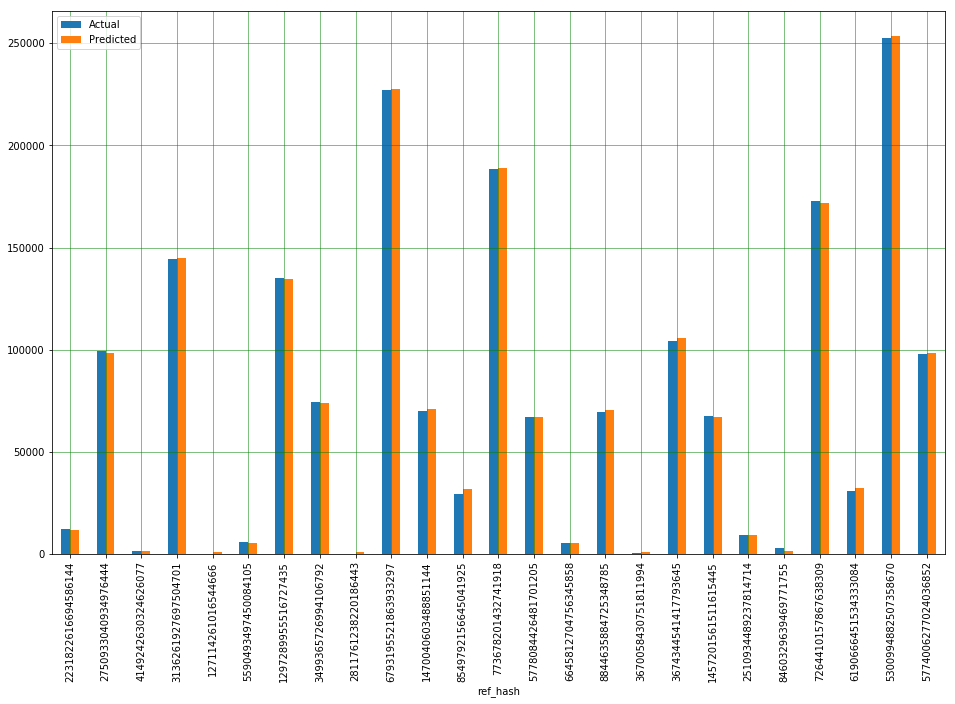

In [14]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [15]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 738.0490684322255
Mean Squared Error: 798820.0731093184
Root Mean Squared Error: 893.7673484242521
R2 Score: 0.9998531489275672


# Generalización para cualquier ventana

In [16]:
def add_features(time_window_df, start_date):
    time_window_df['hour'] = time_window_df['date'].dt.hour.astype(np.int8)
    time_window_df['early_morning'] = time_window_df['date'].map(is_early_morning).astype(np.int8)
    time_window_df['late_evening'] = time_window_df['date'].map(is_late_evening).astype(np.int8)
    time_window_df['weekday'] = time_window_df['date'].dt.weekday.astype(np.int8)
    time_window_df['weekend'] = (time_window_df['weekday'] >= 5).astype(np.int8)
    time_window_df['easter_holiday'] = time_window_df['date'].map(is_easter_holiday).astype(np.int8)
    time_window_df['days_elapsed_since_window_start'] = (time_window_df['date'] - pd.Timestamp(start_date)).astype('timedelta64[D]')
    time_window_df['auction_number_since_window_start'] = np.arange(len(time_window_df))
    time_window_df['new_device_id_since_window_start'] = time_window_df['device_id'].map(is_new_device).astype(np.int8)

In [17]:
def process_time_window(filename, start_date):
    # Leo el .csv, ordeno por fecha
    auctions = pd.read_csv(filename, low_memory=False, parse_dates=['date'])
    auctions = auctions.sort_values(by='date')
    auctions.head()
    
    add_features(auctions, start_date)
    
    # device_id es ref_hash, me quedo con el primer registro (primera fecha) donde aparezca cada hash
    auctions = auctions.rename(index=str, columns={'device_id' : 'ref_hash'})
    auctions = auctions.drop_duplicates(subset='ref_hash')
    auctions = auctions.set_index('ref_hash')
    
    # Ya tengo la fecha mínima para cada ref_hash, resto el momento inicial y convierto a segundos
    auctions['date'] = auctions['date'] - pd.Timestamp(start_date)
    auctions['date'] = auctions['date'].map(lambda x: x.total_seconds())
    return auctions

In [18]:
auctions2 = process_time_window('data/auctions_ventanas/auctions_2019-04-21-2019-04-23.csv', '2019-04-21 00:00:00')
features = auctions2.drop('date', axis=1)
labels = auctions2['date']
X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, test_size=0.2, random_state=123)
#regressor = LinearRegression()
#regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [24]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
ref_hash,,
8645802461165024625,102901.990843,-32099.452104
110500486275379963,62819.445494,163497.232667
4340762931036951528,179435.591103,44612.606424
2813480289265097787,174.091053,101832.976030
2465854437767526116,25252.435843,128030.605531
...,...,...
4495865066766664060,103002.292644,-32068.279078
2413874979445259822,163.038439,101866.924577
9111221541092731058,9950.646928,110715.246114


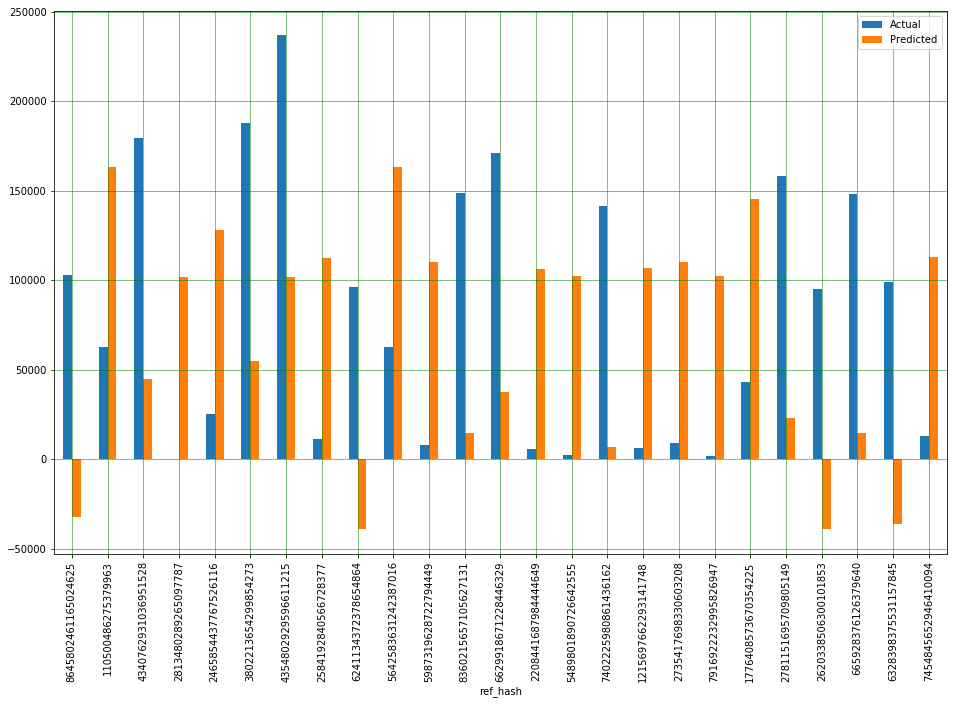

In [25]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [20]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 114177.87761081099
Mean Squared Error: 13307864036.78139
Root Mean Squared Error: 115359.71583174687
R2 Score: -1.4923502730481149


## Exportar los resultados

In [21]:
target = pd.read_csv('data/target_competencia_ids.csv', low_memory=False)
target['ref_hash'] = target['ref_hash'].map(lambda x: x.split('_')[0]).astype(np.int64)
target = target.drop_duplicates(subset='ref_hash')
target

,ref_hash,obj
0,1000169251625791246,0
2,1000395625957344683,0
4,1003027494996471685,0
6,1006670001679961544,0
8,1007573308966476713,0
...,...,...
8064,977508757724050464,0
8066,979880031097032355,0
8068,987443249627191692,0
8070,997953354533822687,0


In [22]:
output = pd.Series(data = y_pred, index = X_test.index, name = 'pred')
output = output.reset_index()
output

,ref_hash,pred
0,8645802461165024625,-32099.452104
1,110500486275379963,163497.232667
2,4340762931036951528,44612.606424
3,2813480289265097787,101832.976030
4,2465854437767526116,128030.605531
...,...,...
65384,4495865066766664060,-32068.279078
65385,2413874979445259822,101866.924577
65386,9111221541092731058,110715.246114
65387,3702081204927278924,112548.670755


In [23]:
output = output.merge(target_hash, on='ref_hash', how='right')
output = output.fillna(3*24*60*60)
#output.to_csv("auctions_linear.csv", index=False)
output

NameError: name 'target_hash' is not defined